## Arbol de clasificación



En este LAB vamos a modelar un arbol de clasificación usando las librerías de **scikit-learn** para poder predecir la probabilidad de un atáque cardíaco. Usaremos el dataset Heart.csv para entrenar el modelo con 303 pacientes.

Si indica presencia de enfermedad cardíaca diagnosticada. Tenemos 3 features: la edad, el sexo, el colesterol (una medida del colesterol) y otros tipos de corazón y mediciones de la función pulmonar.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Cargamos el dataset
data = pd.read_csv("heart.csv") 
print (data.AHD.value_counts())
print ("las clases estan levemente desbalanceadas, podria evaluarse hacer feature sampling en un segundo procedimiento")

No     164
Yes    139
Name: AHD, dtype: int64
las clases estan levemente desbalanceadas, podria evaluarse hacer feature sampling en un segundo procedimiento


In [3]:
print ("tamaño antes de dropear nulos", data.shape)
#drop nulls
data = data.dropna(axis=0, how='any') 
print ("tamaño luego de dropear nulos",data.shape)
data.head()

tamaño antes de dropear nulos (303, 14)
tamaño luego de dropear nulos (297, 14)


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [4]:
#dropeamos la variable target y creamos variables dummies para las variables categoricas
X = pd.get_dummies(data.drop(columns='AHD'))
y= data.AHD
y = y.map({'Yes': 1, 'No': 0})
atributos = X.columns

In [5]:
# sets de entrenamiento-prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [6]:
#importamos de sklearn el clasificador. Lo fiteamos con hiperparámetros determinados para una primer acercamiento
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
treeclf = DecisionTreeClassifier(max_depth=3, criterion='gini', class_weight = 'balanced', max_features=3, max_leaf_nodes=4)
treeclf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
                       max_features=3, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [7]:
# Calcular la importancia de los atributos
pd.DataFrame({'Atributo':atributos,
              'importancia':treeclf.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).head()

,Atributo,importancia
11,ChestPain_asymptomatic,0.660254
10,Ca,0.212743
6,MaxHR,0.127003
0,Age,0.000000
16,Thal_normal,0.000000


score de la clasificación en test -  0.75556 %


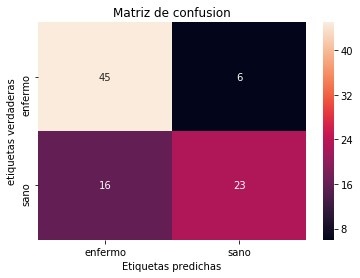

In [19]:
#miramos la matriz de confusion 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

y_pred = treeclf.predict(X_test)
conf = confusion_matrix(y_test, treeclf.predict(X_test))

ax= plt.subplot()
sns.heatmap(conf, annot=True, ax = ax); #annot=True to annotate cells

# tipo de etiquetas, titulo y etiquetas 
ax.set_xlabel('Etiquetas predichas');ax.set_ylabel('etiquetas verdaderas'); 
ax.set_title('Matriz de confusion'); 
ax.xaxis.set_ticklabels(['enfermo', 'sano']); ax.yaxis.set_ticklabels(['enfermo', 'sano']);

print("score de la clasificación en test - ",treeclf.score(X_test, y_test).round(5),"%")


Vemos que el modelo tiene una efectividad moderada para predecir ambas clases. Para mejorar la predicción vamos a probar en vez de fijar hiperparámetros a priori, correr un **Grid Search** y probar varios sets de hiperparámetros hasta encontrar la mejor combinación.


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

PARAMETROS = {'max_depth':[1,2,3,4,5,6], 'max_features':[1,2,3,4], 
              'max_leaf_nodes':[4,5,6,7], 'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[2,3,4]}

kf = StratifiedKFold(n_splits=5, shuffle=True)

#Se hace la búsqueda con Grid Search
model = DecisionTreeClassifier(random_state=1, class_weight = 'balanced')
gs = GridSearchCV(model, PARAMETROS, verbose=1 , n_jobs=-1, cv=kf)
gs.fit(X_train, y_train)

# Se muestran los mejores resultados
print(gs.best_estimator_)
print(gs.best_score_)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 2272 tasks      | elapsed:   17.1s


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=2, max_leaf_nodes=7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')
0.7874396135265701


[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:   30.7s finished
C:\Users\Joaquin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


score de la clasificación en test -  0.72222 %


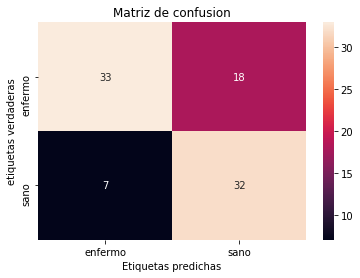

In [18]:
tree_final = gs.best_estimator_.fit(X_train, y_train)

conf_gs = confusion_matrix(y_test, tree_final.predict(X_test))

ax= plt.subplot()
sns.heatmap(conf_gs, annot=True, ax = ax); #annot=True to annotate cells

# tipo de etiquetas, titulo y etiquetas 
ax.set_xlabel('Etiquetas predichas');ax.set_ylabel('etiquetas verdaderas'); 
ax.set_title('Matriz de confusion'); 
ax.xaxis.set_ticklabels(['enfermo', 'sano']); ax.yaxis.set_ticklabels(['enfermo', 'sano']);

print("score de la clasificación en test - ",tree_final.score(X_test, y_test).round(5),"%")
